## 範例
在『[keras_cnn_mnist](https://github.com/shaoeChen/deeplearning/blob/master/keras/keras_cnn_mnist.ipynb)』中，我們利用了`keras.models.Sequential`建置模型，這邊我們練習透過`keras.models.Model`來建置。  
整體流程來說，資料預處理與最後的最佳化設置是相同的，唯一模型建置上我們會設置一個function，並在function內建置好模型之後回傳物件

In [6]:
#  載入需求套件
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Input
from keras.optimizers import SGD
import numpy as np
import pandas as pd

In [10]:
#  載入資料集
(X_train_original, y_train_original), (X_test_original, y_test_original) = mnist.load_data()

資料集載入之後，首要即為確認資料維度，可以確認訓練集有60000，照片維度為28x28，而測試資料集有10000。

In [12]:
print('train_data_dimension:', X_train_original.shape)
print('train_data:', X_train_original.shape[0])
print('train_label_dimension:', y_train_original.shape)
print('test_data:', X_test_original.shape[0])
print('test_label_dimension:', y_test_original.shape)

train_data_dimension: (60000, 28, 28)
train_data: 60000
train_label_dimension: (60000,)
test_data: 10000
test_label_dimension: (10000,)


確認維度之後，我們要開始執行資料的前置預處理，主要有三：
1. 維度的調整，照片本身為28x28，預計將它調整為28x28x1，這可利用`np.reshape`來達成
2. 調整之後的資料統一/255做標準化，將資料縮放至0-1之間
3. lable的調整，預計輸出10個類別(0-9)，要將類別轉為one-hot來表示，keras內置工具'np_utils.to_categorical'可協助。

在CNN中，究竟是pixel x pixel x channel還是channel x pixel x pixel並沒有一個定論，如果你的bacnend為theano，那就必需以後者為主，如果是tensorflow那就以前者為主。

In [13]:
#  資料標準化
X_train_norm = X_train_original / 255
X_test_norm = X_test_original / 255

#  資料維度調整
X_train = X_train_norm.reshape((X_train_norm.shape[0], X_train_norm.shape[1], X_train_norm.shape[2], 1))
X_test = X_test_norm.reshape((X_test_norm.shape[0], X_test_norm.shape[1], X_test_norm.shape[2], 1))

#  lable執行one-hot encoder
#  參數10代表轉為10個類別
y_train = np_utils.to_categorical(y_train_original, 10)
y_test = np_utils.to_categorical(y_test_original, 10)

調整之後，記得再次的確認目前的資料維度

In [14]:
print('train_data_dimension:', X_train.shape)
print('test_data_dimension:', X_test.shape)
print('train_label_dimension:', y_train.shape)
print('test_label_dimension:', y_test.shape)

train_data_dimension: (60000, 28, 28, 1)
test_data_dimension: (10000, 28, 28, 1)
train_label_dimension: (60000, 10)
test_label_dimension: (10000, 10)


前置預處理對於於DNN還需要平整化是相對簡單，接下來就可以開始組裝模型，keras的開發之初即是希望從業人員可以專注意模型的建立，而不是程式的編寫。

預計利用keras來實作LeNet-5做手寫辨識，用著我們從Yann LeCun身上學習到的知識來建置他所開發的模型。

LeNet-5的『5』所指為5層，一般來說有權重參數的才會算是一層，故pooling不算，兩層conv，三層fully connect，共計五層。    


[LeNet](http://yann.lecun.com/exdb/lenet/)  
網站上有著各層提取特徵的可視化

下面，我們建立一個function，參數為輸入的dimension與預測類別的數量，最後回傳物件model，更詳細的說明可見[官方文件](https://keras.io/zh/getting-started/functional-api-guide/#_1)  

In [16]:
def LeNet_5(input_shape, output_class):
    input_shape = Input(shape=(input_shape))
    X = Conv2D(filters=6, kernel_size=(5, 5), padding='valid', activation='tanh', name='Conv_1')(input_shape)
    X = MaxPool2D(pool_size=(2, 2), name='MaxPool_1')(X)
    X = Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh', name='Conv_2')(X)
    X = MaxPool2D(pool_size=(2, 2), name='MaxPool_2')(X)
    X = Flatten(name='Flatten_1')(X)
    X = Dense(120, activation='tanh', name='Fully_Connected_1')(X)
    X = Dense(84, activation='tanh', name='Fully_Connected_2')(X)
    output = Dense(output_class, activation='softmax', name='Output_softmax')(X)
    
    model = Model(inputs = input_shape, outputs=output, name='LeNet_5')
    return model

又或許，你也不一定要以function的方式來執行，這部份依實務需求調整即可    
```python
input_shape = Input(shape=(input_shape))
X = Conv2D(filters=6, kernel_size=(5, 5), padding='valid', activation='tanh', name='Conv_1')(input_shape)
X = MaxPool2D(pool_size=(2, 2), name='MaxPool_1')(X)
X = Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh', name='Conv_2')(X)
X = MaxPool2D(pool_size=(2, 2), name='MaxPool_2')(X)
X = Flatten(name='Flatten_1')(X)
X = Dense(120, activation='tanh', name='Fully_Connected_1')(X)
X = Dense(84, activation='tanh', name='Fully_Connected_2')(X)
output = Dense(output_class, activation='softmax', name='Output_softmax')(X)

model = Model(inputs = input_shape, outputs=output, name='LeNet_5')
```

In [18]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
input_shape

(28, 28, 1)

In [19]:
model = LeNet_5(input_shape=input_shape, output_class=y_train.shape[1])

In [22]:
#  確認模型架構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 12, 12, 6)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 8, 8, 16)          2416      
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 4, 4, 16)          0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
Fully_Connected_1 (Dense)    (None, 120)               30840     
__________

架構好模型之後，要定義最佳化的方式，這可利用`keras.model.compile`來設置。

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1),
              metrics=['accuracy'])

可以開始訓練模型了，利用`keras.model.fit`，並設置batch_size與Epochs，訓練期間我們也拆分了20%的資料集做驗證使用。

In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20,
                    validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 30s 619us/step - loss: 0.3840 - acc: 0.8951 - val_loss: 0.1587 - val_acc: 0.9558
Epoch 2/20
48000/48000 [==============================] - 29s 607us/step - loss: 0.1280 - acc: 0.9635 - val_loss: 0.1027 - val_acc: 0.9705
Epoch 3/20
48000/48000 [==============================] - 29s 604us/step - loss: 0.0872 - acc: 0.9749 - val_loss: 0.0810 - val_acc: 0.9753
Epoch 4/20
48000/48000 [==============================] - 29s 596us/step - loss: 0.0692 - acc: 0.9799 - val_loss: 0.0711 - val_acc: 0.9792
Epoch 5/20
48000/48000 [==============================] - 28s 590us/step - loss: 0.0570 - acc: 0.9832 - val_loss: 0.0630 - val_acc: 0.9817
Epoch 6/20
48000/48000 [==============================] - 28s 585us/step - loss: 0.0494 - acc: 0.9851 - val_loss: 0.0583 - val_acc: 0.9829
Epoch 7/20
48000/48000 [==============================] - 28s 593us/step - loss: 0.0434 - acc: 0.9871 - val_loss: 0.

下面我們利用圖面來確認模型狀況，請先執行最下方的function，詳見function說明。  
看的出來模型本身存在著overfitting的問題，但cost function是有確實的收斂。

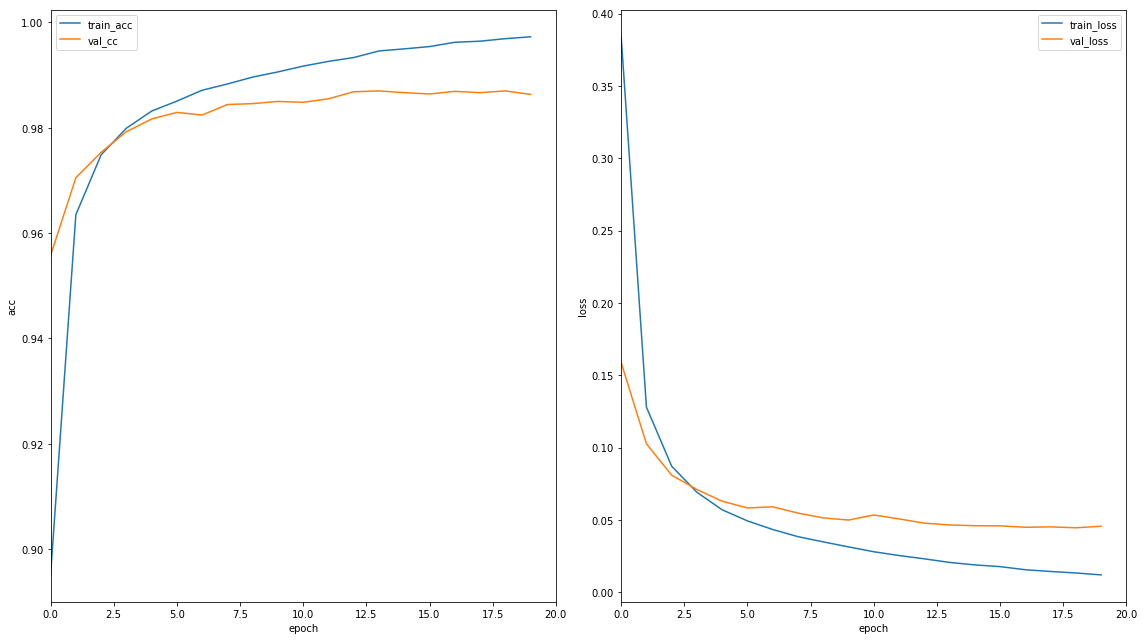

In [29]:
model_history_plot(history=history.history, epoch=history.epoch)

訓練完畢之後就可以確認模型性能狀況，

In [30]:
#  請先執行最下面的function
ds_predict = utils_predict(model, {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test})

10000/10000 [==============================] - 4s 364us/step


In [31]:
print('train_score:', ds_predict['train_score'])
print('tes_score:', ds_predict['test_score'])

train_score: 0.9954666666666667
tes_score: 0.9891


透過混肴矩陣可以清楚的看出模型中true label與predict label的相關性，這可利用pandas.crosstab來達成，相關的predict label我們記錄在稍早所執行的function所回傳的ds_predict中。

In [32]:
pd.crosstab(y_test_original, ds_predict['test_predict'], rownames=['test_label'], colnames=['predict_label'])

predict_label,0,1,2,3,4,5,6,7,8,9
test_label,,,,,,,,,,
0,976,0,1,0,0,0,2,1,0,0
1,0,1133,1,0,0,0,1,0,0,0
2,1,3,1022,0,2,0,0,4,0,0
3,0,0,2,997,0,4,0,2,2,3
4,0,0,1,0,975,0,3,0,0,3
5,2,0,0,7,0,876,3,1,0,3
6,4,3,0,1,1,2,946,0,1,0
7,0,2,2,1,0,0,0,1020,1,2
8,4,0,4,2,0,0,1,3,958,2


最後，我們可以利用遮罩來單純的檢視判斷錯誤的部份，這有利於調整模型，以此判斷究竟是資料集本身的問題還是模型的問題，該如何調整overfitting..等問題。

執行之前請記得先執行最下面的function

In [33]:
#  先設置遮罩
mask_train = y_train_original != ds_predict['train_predict']
mask_test = y_test_original != ds_predict['test_predict']

In [34]:
#  確認錯誤筆數
print('train_error_count:', y_train_original[mask_train].shape[0])
print('test_error_count:', y_test_original[mask_test].shape[0])

train_error_count: 272
test_error_count: 109


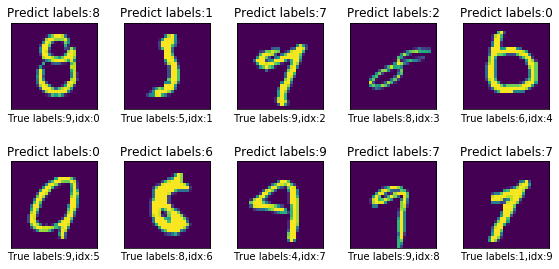

In [35]:
plt_image(X_train_original[mask_train], y_train_original[mask_train], predict_labels=ds_predict['train_predict'][mask_train],
          idx_start=0, idx_batch_size=10, fig_size='small')

以下為自己寫的function，請先執行。

In [26]:
def utils_predict(model, datasets, evaluate=True, need_prob=False):
    """
    keras預測之後回傳為概率，透過此function可轉為類別
    再依需求調控是否回傳概率與模型效能評估
    
    model:keras.model，訓練之後的模型
    datasets:資料集，格式為dict，索引名稱必需為X_train, X_test, y_train, y_test
        datasets:
            'X_train':train_dataset
            'X_test':test_dataset
            'y_train':train_label
            'y_test':test_label
    evaluate:是否執行model.evaluate，如果是，那資料集就必需有y_train與y_test
    need_prob:是否回傳概率
    
    return datasets
        預測類別：
            train_predict, test_predict
        預測概率：
            train_predict_prob, test_predict_prob
        模型評估：
            train_score, test_score
        
    datasets:dict    
    """
    train_dataset = datasets['X_train']
    test_dataset = datasets['X_test']
    
    train_prob = model.predict(train_dataset, verbose=1)
    test_prob = model.predict(test_dataset, verbose=1)
    
    train_labels = train_prob.argmax(axis=-1)
    test_labels = test_prob.argmax(axis=-1)
    
    datasets['train_predict'] = train_labels
    datasets['test_predict'] = test_labels
    
    if evaluate:
        scores_train = model.evaluate(X_train, y_train)
        scores_test = model.evaluate(X_test, y_test)
        datasets['train_score'] = scores_train[1]
        datasets['test_score'] = scores_test[1]
        
    if need_prob:
        datasets['train_predict_prob'] = train_prob
        datasets['test_predict_prob'] = test_prob
        
    
    return datasets

In [27]:
#  產生圖面(acc，val)
import matplotlib.pyplot as plt
def model_history_plot(history, epoch):
    """
    history:訓練記錄，為keras.History.history
    epoch:迭代次數，為keras.History.epoch
    
    首先判斷物件長度是否為4，如果是那代表有啟用驗證資料集，若為2，就代表只有訓練資料集。
    """
    #  用以判斷是否有驗證資料集，如果dict長度為4則賦值為True
    val = False
    
    if len(history)==4:
        val = True
        val_acc = history['val_acc']
        val_loss = history['val_loss']
        
    acc = history['acc']
    loss = history['loss']
       
    #  設置圖表
    plt.figure(figsize=(16,9))
    
    #  準確度_acc
    plt.subplot(121)
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.xlim(min(epoch), max(epoch)+1)
    plt.plot(epoch, acc, label='train_acc')
    
    if val:
        plt.plot(epoch, val_acc, label='val_cc')
    plt.legend(loc='best')
    
    #  訓練成本_loss
    plt.subplot(122)    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlim(min(epoch), max(epoch)+1)
    plt.plot(epoch, loss, label='train_loss')
    
    if val:
        plt.plot(epoch, val_loss, label='val_loss')            
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

In [28]:
import math

def plt_image(images, labels, predict_labels=[], idx_start=0, idx_batch_size=10, cel_num=5, fig_size='big'):
    """
    images:來源照片(x)
    labels：來源照片類別(y)
    predict_labels:預測照片類別
    idx_start:起始索引
        預設為0
    idx_batch_size:每次讀取量
        預設為10
    cel_num:每row顯示幾張照片
        預設為5
    fig_size:figure.figsize設置
        big:16,9
        middle:12,7
        small:8,4
        
    當每次讀取批量>20的時候會以20取值
    如果照片想要大點來看，就必需將cel_num設置小一點，然後設置size為big或是middle
    """
    #  判斷索引值是否超過10，若超過20則idx_batch_size重新賦值
    if idx_batch_size > 20:
        idx_batch_size = 20   
    
    rows = int(math.ceil(idx_batch_size / cel_num))
    
    if fig_size=='big':
        _size=(16, 9)
    elif fig_size=='middle':
        _size=(12, 7)
    elif fig_size=='small':
        _size=(8, 4)
        
    #  設置圖表尺寸
    plt.figure(figsize=(_size))
    for i in range(idx_batch_size): 
        ax = plt.subplot(rows,cel_num,i+1)
        #  取消x、y軸的刻度
        plt.xticks(())        
        plt.yticks(())
        #  設置x軸的label為
        ax.set_xlabel('True labels:' + str(labels[idx_start]) + ',idx:' + str(idx_start))
        #  如果predict_labls不是空值，那就帶入資料
        if len(predict_labels)>0:            
            ax.set_title('Predict labels:' + str(predict_labels[idx_start]))
        ax.imshow(images[idx_start])
        #  換下一筆
        idx_start += 1        
         
    #  確保資料呈現正常    
    plt.tight_layout()    
    plt.show()        